In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
from tqdm import tqdm
import hiplot as hip

In [3]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset

In [4]:
cwd = os.getcwd()
print(cwd)

/cluster/home/skyriakos/chemprop_run/git/notebooks


In [5]:
os.chdir('..')
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
# from deepadr.model_gnn import GCN as testGCN
from deepadr.model_gnn_ogb import GNN, DeepAdr_SiameseTrf, ExpressionNN
# from deepadr.model_attn_siamese import *
from ogb.graphproppred import Evaluator
os.chdir(cwd)

In [6]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [7]:
# from tdc.single_pred import Tox
# from tdc.multi_pred import DDI

In [8]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [9]:
report_available_cuda_devices()

number of GPUs available: 8
cuda:0, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:1, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:2, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:3, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:4, name:GeForce GTX 1080 Ti
total memory av

In [10]:
n_gpu = torch.cuda.device_count()
n_gpu

8

In [11]:
device_cpu = get_device(to_gpu=False)
device_gpu = get_device(True, index=0)

fdtype = torch.float32

In [12]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)

torch: 1.9.1
CUDA: 11.1


In [13]:
# print(torch.cuda.memory_summary(device=device_gpu))

### Preparing dataset 

In [14]:
# TDC Tox
DSdataset_name = 'MatchMakerDrugComb' #'OncoPolyPharmacology' #'DrugComb'

#fname_suffix = ds_config["fname_suffix"]
similarity_types = ['chem']
kernel_option = 'sqeuclidean'
data_fname = 'data_v1'
# interact_matfname = ds_config["interact_matfname"]
# exp_iden = 'simtypeall'
# ddi_interaction_labels_pth = ds_config["ddi_interaction_labels_pth"]

# up_dir, processed_dir, DSdataset_name, data_fname

In [15]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
# # ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))
print(targetdata_dir)

path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
/cluster/home/skyriakos/chemprop_run/git/data/processed/MatchMakerDrugComb/data_v1


In [16]:
%%time

# Make sure to first run the "data_generation" notebook first

dataset = MoleculeDataset(root=targetdata_dir)

CPU times: user 718 µs, sys: 538 ms, total: 539 ms
Wall time: 537 ms


In [17]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data0 = dataset[0]  # Get the first graph object.

# print()
# print(data)
# print('=============================================================')

# # Gather some statistics about the first graph.
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
# print(f'Contains self-loops: {data.contains_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')


Dataset: MoleculeDataset(96671):
Number of graphs: 96671
Number of features: 9
Number of classes: 2


In [18]:
data0

PairData(edge_index_a=[2, 68], x_a=[31, 9], edge_attr_a=[68, 3], edge_index_b=[2, 76], x_b=[35, 9], edge_attr_b=[76, 3], id=[1], y=[1], expression=[1, 972])

In [19]:
data0.expression.shape

torch.Size([1, 972])

In [20]:
data0.y

tensor([0], dtype=torch.int32)

In [21]:
len(dataset)

96671

In [22]:
# used_dataset = dataset

# If you want to use a smaller subset of the dataset for testing
smaller_dataset_len = int(len(dataset)/20)
used_dataset = dataset[:smaller_dataset_len]

In [23]:
fold_partitions = get_stratified_partitions(used_dataset.data.y[:smaller_dataset_len],
                                            num_folds=5, valid_set_portion=0.1, random_state=42)

fold_num: 0
train data
class: 0 norm count: 0.967519402127048
class: 1 norm count: 0.032480597872951995
validation data
class: 0 norm count: 0.9664082687338501
class: 1 norm count: 0.03359173126614987
test data
class: 0 norm count: 0.9669079627714581
class: 1 norm count: 0.033092037228541885

-------------------------
fold_num: 1
train data
class: 0 norm count: 0.967519402127048
class: 1 norm count: 0.032480597872951995
validation data
class: 0 norm count: 0.9664082687338501
class: 1 norm count: 0.03359173126614987
test data
class: 0 norm count: 0.9669079627714581
class: 1 norm count: 0.033092037228541885

-------------------------
fold_num: 2
train data
class: 0 norm count: 0.967519402127048
class: 1 norm count: 0.032480597872951995
validation data
class: 0 norm count: 0.9664082687338501
class: 1 norm count: 0.03359173126614987
test data
class: 0 norm count: 0.9669079627714581
class: 1 norm count: 0.033092037228541885

-------------------------
fold_num: 3
train data
class: 0 norm cou

In [24]:
# train_val_test_frac = [0.7, 0.1, 0.2]
# assert sum(train_val_test_frac) == 1

# torch.manual_seed(42)
# used_dataset = used_dataset.shuffle()

# num_train = round(train_val_test_frac[0] * len(used_dataset)) 
# num_trainval = round((train_val_test_frac[0]+train_val_test_frac[1]) * len(used_dataset))

# train_dataset = used_dataset[:num_train]
# val_dataset = used_dataset[num_train:num_trainval]
# test_dataset = used_dataset[num_trainval:]

In [25]:
train_dataset = Subset(used_dataset, fold_partitions[0]['train'])
val_dataset = Subset(used_dataset, fold_partitions[0]['validation'])
test_dataset = Subset(used_dataset, fold_partitions[0]['test'])

In [26]:
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 3479
Number of val graphs: 387
Number of test graphs: 967


In [27]:
print(dataset.num_classes)

2


In [28]:
# train_dataset[3]

In [29]:
# training params
tp = {
    "batch_size" : 256,
    "num_epochs" : 1,
    
    "emb_dim" : 300,
    "gnn_type" : "gatv2",
    "num_layer" : 5,
    "graph_pooling" : "mean", #attention
    
    "input_embed_dim" : None,
    "gene_embed_dim": 8,
    "num_attn_heads" : 2,
    "num_transformer_units" : 1,
    "p_dropout" : 0.3,
    "nonlin_func" : nn.ReLU(),
    "mlp_embed_factor" : 2,
    "pooling_mode" : 'attn',
    "dist_opt" : 'cosine',

    "base_lr" : 3e-5, #3e-4
    "l2_reg" : 1e-7,
    "loss_w" : 0.1,
    "margin_v" : 1.,

    "expression_dim" : 64,
    "expression_input_size" : 972,
    "exp_H1" : 500,
    "exp_H2" : 400
}

In [30]:
train_loader = DataLoader(train_dataset, batch_size=tp["batch_size"], shuffle=True, follow_batch=['x_a', 'x_b'])
valid_loader = DataLoader(val_dataset, batch_size=tp["batch_size"], shuffle=False, follow_batch=['x_a', 'x_b'])
test_loader = DataLoader(test_dataset, batch_size=tp["batch_size"], shuffle=False, follow_batch=['x_a', 'x_b'])

In [31]:
gnn_model = GNN(gnn_type = tp["gnn_type"], 
#                 num_tasks = dataset.num_classes, 
                num_layer = tp["num_layer"], 
                emb_dim = tp["emb_dim"], 
                drop_ratio = 0.5, 
                JK = "multilayer", #last
                graph_pooling = tp["graph_pooling"],
                virtual_node = False,
                with_edge_attr=False).to(device=device_gpu, dtype=fdtype)

In [32]:
transformer_model = DeepAdr_Transformer(input_size=tp["expression_input_size"],
                                        input_embed_dim=tp["input_embed_dim"],
                                        num_attn_heads=tp["num_attn_heads"],
                                        mlp_embed_factor=tp["mlp_embed_factor"],
                                        nonlin_func=tp["nonlin_func"],
                                        pdropout=tp["p_dropout"],
                                        num_transformer_units=tp["num_transformer_units"],
                                        pooling_mode=tp["pooling_mode"],
                                        gene_embed_dim=tp['gene_embed_dim']).to(device=device_gpu, dtype=fdtype)

In [33]:
# expression_model = ExpressionNN(D_in=tp["expression_input_size"],
#                                 H1=tp["exp_H1"], H2=tp["exp_H2"],
#                                 D_out=tp["expression_dim"], drop=0.5).to(device=device_gpu, dtype=fdtype)

In [34]:
siamese_model = DeepAdr_SiameseTrf(input_dim=tp["emb_dim"],
                                   dist=tp["dist_opt"],
                                   expression_dim=tp["gene_embed_dim"],
                                   num_classes=dataset.num_classes).to(device=device_gpu, dtype=fdtype)

updated
num classes: 2


In [35]:
# lasso_input_dim = 2*tp["emb_dim"]+1+expression_input_size
# lasso_out_dim = dataset.num_classes

# lassonet_model = LassoNet(lasso_input_dim, lasso_out_dim)

In [36]:
# models_param = list(gnn_model.parameters()) + list(transformer_model.parameters()) + list(siamese_model.parameters()) + list(expression_model.parameters())
models_param = list(gnn_model.parameters()) + list(transformer_model.parameters()) + list(siamese_model.parameters())


model_name = "ogb"
models = [(gnn_model, f'{model_name}_GNN'),
          (transformer_model, f'{model_name}_Transformer'),
          (siamese_model, f'{model_name}_Siamese'),
#           (expression_model, f'{model_name}_Expression'),
#           (lassonet_model, f'{model_name}_LassoNet')
         ]
#models

In [37]:
y_weights = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y_weights.pkl'))
class_weights = torch.tensor(y_weights).type(fdtype).to(device_gpu)
class_weights

tensor([0.5313, 8.4829], device='cuda:0')

In [38]:
# from IPython.display import Javascript
# display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

num_iter = len(train_loader)  # num_train_samples/batch_size
c_step_size = int(np.ceil(5*num_iter))  # this should be 2-10 times num_iter

base_lr = tp['base_lr']
max_lr = 10*base_lr  # 3-5 times base_lr
optimizer = torch.optim.Adam(models_param, weight_decay=tp["l2_reg"], lr=base_lr)
cyc_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=c_step_size,
                                                mode='triangular', cycle_momentum=False)
# optimizer = torch.optim.Adam(models_param, lr=0.001)
# criterion = torch.nn.CrossEntropyLoss()

# loss_nlll = torch.nn.NLLLoss(weight=class_weights, reduction='mean')  # negative log likelihood loss
loss_nlll = torch.nn.NLLLoss(weight=class_weights, reduction='mean')  # negative log likelihood loss
loss_contrastive = ContrastiveLoss(0.5, reduction='mean')
# loss_mse = torch.nn.MSELoss()  # this is for regression mean squared loss


# evaluator = Evaluator(DSdataset_name)

In [39]:
def train():
    for m, m_name in models:
        m.train()

        #            for i_batch, samples_batch in enumerate(data_loader):

#     for data in train_loader:  # Iterate in batches over the training dataset.
    for i_batch, batch in enumerate(tqdm(train_loader, desc="Iteration")):
        batch = batch.to(device_gpu)

#         print("running batch:", i_batch)
        # x, edge_index, edge_attr, batch
        h_a = gnn_model(batch.x_a, batch.edge_index_a, batch.edge_attr_a, batch.x_a_batch)
        h_b = gnn_model(batch.x_b, batch.edge_index_b, batch.edge_attr_b, batch.x_b_batch)
        
#         print("h_a shape:", h_a.shape)
        
#         z_a, fattn_w_scores_a = transformer_model(h_a)
#         z_b, fattn_w_scores_b = transformer_model(h_b)
        
#         z_e = expression_model(batch.expression.type(fdtype))
        
        transformer_input = torch.unsqueeze(batch.expression.type(fdtype), dim=1)
        z_e, fattn_w_scores_e = transformer_model(transformer_input)
        
#         print("h_a shape:", h_a.shape)
#         print("h_b shape:", h_b.shape)
#         print("transformer_input shape:", transformer_input.shape)
#         print("z_e shape:", z_e.shape)
#         print("fattn_w_scores_e shape:", fattn_w_scores_e.shape)
        
#         print("h_a dtype:", h_a.dtype)
#         print("h_b dtype:", h_b.dtype)
#         print("z_e dtype:", z_e.dtype)
        
#         if (i_batch == 0):
#             print(torch.cuda.memory_summary(device=device_gpu))
        
        logsoftmax_scores, dist = siamese_model(h_a, h_b, z_e)
#         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
#         loss = criterion(out, samples_batch.y)  # Compute the loss.
#         print(pd.Series(batch.y.cpu()).value_counts())
        cl = loss_nlll(logsoftmax_scores, batch.y.type(torch.long))            
        dl = loss_contrastive(dist.reshape(-1), batch.y.type(fdtype))          
        loss = tp["loss_w"]*cl + (1-tp["loss_w"])*dl
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        cyc_scheduler.step() # after each batch step the scheduler
        optimizer.zero_grad()  # Clear gradients.

def eval(loader, dsettype):
    for m, m_name in models:
        m.eval()
        
    pred_class = []
    ref_class = []
    prob_scores = []
    
    fattn_w_scores_e_ids = []
    
#     for data in loader:  # Iterate in batches over the training/test dataset.
    for i_batch, batch in enumerate(tqdm(loader, desc="Iteration")):
        batch = batch.to(device_gpu)
#         out = model(data.x, data.edge_index, data.batch)  
        h_a = gnn_model(batch.x_a, batch.edge_index_a, batch.edge_attr_a, batch.x_a_batch)
        h_b = gnn_model(batch.x_b, batch.edge_index_b, batch.edge_attr_b, batch.x_b_batch)
        
#         z_a, fattn_w_scores_a = transformer_model(h_a)
#         z_b, fattn_w_scores_b = transformer_model(h_b)
        
#         z_e = expression_model(batch.expression.type(fdtype))

        transformer_input = torch.unsqueeze(batch.expression.type(fdtype), dim=1)
        z_e, fattn_w_scores_e = transformer_model(transformer_input)
        
        if (dsettype=="test"):
            print("fattn_w_scores_e shape:", fattn_w_scores_e.shape)
            print("batch id shape:", batch.id.shape)
            
            fattn_w_scores_e_ids.append(torch.cat((batch.id.unsqueeze(1), fattn_w_scores_e), 1))

        
#         logsoftmax_scores, dist = deepadr_siamese(z_a, z_b)
        
#         __, y_pred_clss = torch.max(logsoftmax_scores, -1)
#         y_pred_prob  = torch.exp(logsoftmax_scores.detach().cpu()).numpy()

#         pred_class.extend(y_pred_clss.view(-1).tolist())
#         ref_class.extend(batch.y.view(-1).tolist())
# #         prob_scores.append(y_pred_prob)
#         prob_scores.extend(y_pred_prob.view(-1).tolist())
    
        logsoftmax_scores, dist = siamese_model(h_a, h_b, z_e)

        __, y_pred_clss = torch.max(logsoftmax_scores, -1)

        y_pred_prob  = torch.exp(logsoftmax_scores.detach().cpu()).numpy()

        pred_class.extend(y_pred_clss.view(-1).tolist())
        ref_class.extend(batch.y.view(-1).tolist())
        prob_scores.append(y_pred_prob)

    prob_scores_arr = np.concatenate(prob_scores, axis=0)
#     print("pred_class", pred_class)
#     print("ref_class", ref_class)
    modelscore = perfmetric_report(pred_class, ref_class, prob_scores_arr[:,1], epoch,
                                  outlog = os.path.join(targetdata_dir_processed, dsettype + ".log"))
#     modelscore = perfmetric_report(pred_class, ref_class, prob_scores, epoch, "")        
    
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
#         correct += int((pred == samples_batch.y).sum())  # Check against ground-truth labels.
#     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

    if (dsettype=="test"):
        fattn_w_scores_e_ids_np = torch.cat(fattn_w_scores_e_ids).detach().cpu().numpy()
        df_fattn_w_scores_e_ids = pd.DataFrame(fattn_w_scores_e_ids_np)
        df_fattn_w_scores_e_ids.columns = ["id"] + ["gex"+str(i) for i in range(972)]
        df_fattn_w_scores_e_ids.to_csv(os.path.join(targetdata_dir_processed, "fattn_w_scores_e_ids_test" + ".csv"))

    return modelscore

In [40]:
valid_curve = []
test_curve = []
train_curve = []

In [41]:
%%time

for epoch in range(tp["num_epochs"]):
# for epoch in range(60,70):
    print("=====Epoch {}".format(epoch))
    print('Training...')
#     train(model, device, train_loader, optimizer, dataset.task_type)
    train()

    print('Evaluating...')
#     train_perf = eval(model, device, train_loader, evaluator)
#     valid_perf = eval(model, device, valid_loader, evaluator)
#     test_perf = eval(model, device, test_loader, evaluator)
    train_perf = eval(train_loader, dsettype="train")
    valid_perf = eval(valid_loader, dsettype="valid")
    test_perf = eval(test_loader, dsettype="test")

    print({'Train': train_perf, 'Validation': valid_perf, 'Test': test_perf})

    train_curve.append(train_perf.s_aupr)
    valid_curve.append(valid_perf.s_aupr)
    test_curve.append(test_perf.s_aupr)

# if 'classification' in dataset.task_type:
best_val_epoch = np.argmax(np.array(valid_curve))
best_train = max(train_curve)
# else:
#     best_val_epoch = np.argmin(np.array(valid_curve))
#     best_train = min(train_curve)

print('Finished training!')
print('Best validation score: {}'.format(valid_curve[best_val_epoch]))
print('Test score: {}'.format(test_curve[best_val_epoch]))

=====Epoch 0
Training...


Iteration:   0%|                                                                                                                                                                                                       | 0/14 [00:00<?, ?it/s]

X shape: torch.Size([256, 972, 1])
z shape: torch.Size([256, 972, 8])
z after trf shape: torch.Size([256, 972, 8])
z after attn shape: torch.Size([256, 8])
fattn_w_norm shape: torch.Size([256, 972])


Iteration:   7%|█████████████▋                                                                                                                                                                                 | 1/14 [00:02<00:27,  2.10s/it]

X shape: torch.Size([256, 972, 1])
z shape: torch.Size([256, 972, 8])
z after trf shape: torch.Size([256, 972, 8])
z after attn shape: torch.Size([256, 8])
fattn_w_norm shape: torch.Size([256, 972])


Iteration:  14%|███████████████████████████▎                                                                                                                                                                   | 2/14 [00:03<00:23,  1.93s/it]

X shape: torch.Size([256, 972, 1])
z shape: torch.Size([256, 972, 8])
z after trf shape: torch.Size([256, 972, 8])
z after attn shape: torch.Size([256, 8])
fattn_w_norm shape: torch.Size([256, 972])


Iteration:  21%|████████████████████████████████████████▉                                                                                                                                                      | 3/14 [00:05<00:20,  1.88s/it]

X shape: torch.Size([256, 972, 1])
z shape: torch.Size([256, 972, 8])
z after trf shape: torch.Size([256, 972, 8])
z after attn shape: torch.Size([256, 8])
fattn_w_norm shape: torch.Size([256, 972])


Iteration:  29%|██████████████████████████████████████████████████████▌                                                                                                                                        | 4/14 [00:07<00:18,  1.84s/it]

X shape: torch.Size([256, 972, 1])
z shape: torch.Size([256, 972, 8])
z after trf shape: torch.Size([256, 972, 8])
z after attn shape: torch.Size([256, 8])
fattn_w_norm shape: torch.Size([256, 972])


Iteration:  36%|████████████████████████████████████████████████████████████████████▏                                                                                                                          | 5/14 [00:09<00:16,  1.82s/it]

X shape: torch.Size([256, 972, 1])
z shape: torch.Size([256, 972, 8])
z after trf shape: torch.Size([256, 972, 8])
z after attn shape: torch.Size([256, 8])
fattn_w_norm shape: torch.Size([256, 972])


Iteration:  43%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                                             | 6/14 [00:11<00:14,  1.81s/it]

X shape: torch.Size([256, 972, 1])
z shape: torch.Size([256, 972, 8])
z after trf shape: torch.Size([256, 972, 8])
z after attn shape: torch.Size([256, 8])
fattn_w_norm shape: torch.Size([256, 972])


Iteration:  50%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 7/14 [00:12<00:12,  1.84s/it]

X shape: torch.Size([256, 972, 1])
z shape: torch.Size([256, 972, 8])
z after trf shape: torch.Size([256, 972, 8])
z after attn shape: torch.Size([256, 8])
fattn_w_norm shape: torch.Size([256, 972])


Iteration:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 8/14 [00:14<00:10,  1.82s/it]

X shape: torch.Size([256, 972, 1])
z shape: torch.Size([256, 972, 8])
z after trf shape: torch.Size([256, 972, 8])
z after attn shape: torch.Size([256, 8])
fattn_w_norm shape: torch.Size([256, 972])


Iteration:  57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                 | 8/14 [00:16<00:12,  2.07s/it]


KeyboardInterrupt: 

In [42]:
df_curves = pd.DataFrame(np.array([train_curve, valid_curve, test_curve]).T)
df_curves.columns = ['train', 'valid', 'test']
df_curves.index.name = "epoch"

<AxesSubplot:>

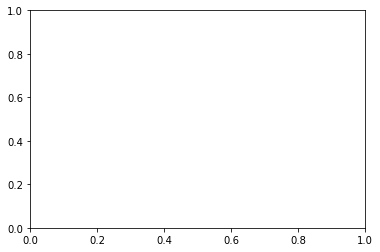

In [43]:
sns.lineplot(data=df_curves)#.figure.savefig("testfig.png")

In [44]:
test_curve

[]

In [45]:
df_curves

,train,valid,test
epoch,,,


In [46]:
a = torch.rand((512,900)) # attn

In [47]:
a.shape

torch.Size([512, 900])

In [48]:
c = torch.rand(512).unsqueeze(1) # ids

In [49]:
c.shape

torch.Size([512, 1])

In [50]:
torch.cat((c,a), 1).shape

torch.Size([512, 901])

In [51]:
sm1 = nn.Softmax(dim=1)

In [52]:
b = sm1(torch.rand((512,900)))

In [53]:
a.mul(b)[0,1]

tensor(0.0007)

In [54]:
b[0,1]

tensor(0.0010)

In [55]:
a[0,1]

tensor(0.6710)

In [56]:
a[0,1] * b[0,1]

tensor(0.0007)

In [57]:
fattn_w_scores_e_ids = []
fattn_w_scores_e_ids.append(a)
fattn_w_scores_e_ids.append(a)
len(fattn_w_scores_e_ids)

2

In [58]:
fattn_w_scores_e_ids

[tensor([[0.0604, 0.6710, 0.1343,  ..., 0.8041, 0.9897, 0.7960],
         [0.8292, 0.1132, 0.0771,  ..., 0.7201, 0.1077, 0.2570],
         [0.1983, 0.8231, 0.7059,  ..., 0.5094, 0.8725, 0.8380],
         ...,
         [0.4449, 0.3663, 0.8155,  ..., 0.4788, 0.8429, 0.6444],
         [0.8385, 0.1133, 0.8249,  ..., 0.9401, 0.6863, 0.1170],
         [0.0692, 0.9353, 0.1499,  ..., 0.0291, 0.7595, 0.5582]]),
 tensor([[0.0604, 0.6710, 0.1343,  ..., 0.8041, 0.9897, 0.7960],
         [0.8292, 0.1132, 0.0771,  ..., 0.7201, 0.1077, 0.2570],
         [0.1983, 0.8231, 0.7059,  ..., 0.5094, 0.8725, 0.8380],
         ...,
         [0.4449, 0.3663, 0.8155,  ..., 0.4788, 0.8429, 0.6444],
         [0.8385, 0.1133, 0.8249,  ..., 0.9401, 0.6863, 0.1170],
         [0.0692, 0.9353, 0.1499,  ..., 0.0291, 0.7595, 0.5582]])]

In [59]:
torch.cat(fattn_w_scores_e_ids).shape

torch.Size([1024, 900])